In [1]:
import scvelo as scv
import scanpy as sc
import pickle as pickle
from eval_utils import cross_boundary_correctness, inner_cluster_coh
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import unitvelo as utv
method = 'scVelo'

(Running UniTVelo 0.2.5)
2023-01-19 10:34:19


In [2]:
dataset = 'MouseErythroid'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.1666993307137321, ('Blood progenitors 2', 'Erythroid1'): 0.038714644729695075, ('Erythroid1', 'Erythroid2'): -0.7686016240365897, ('Erythroid2', 'Erythroid3'): -0.08412495201016568}
Total Mean: -0.2451778155076981
# In-cluster Coherence
{'Blood progenitors 1': 0.8223581492550008, 'Blood progenitors 2': 0.830462467537805, 'Erythroid1': 0.8553807079776226, 'Erythroid2': 0.8813572979197563, 'Erythroid3': 0.8267568620248463}
Total Mean: 0.8432630969430063
# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.1666993307137321, ('Blood progenitors 2', 'Erythroid1'): 0.038714644729695075, ('Erythroid1', 'Erythroid2'): -0.7686016240365897, ('Erythroid2', 'Erythroid3'): -0.08412495201016568}
Total Mean: -0.2451778155076981
# In-cluster Coherence
{'Blood progenitors 1': 0.8223581492550008, 'Blood progenitors 2': 0.830462467537805, 'Erythroid1': 0.855380707

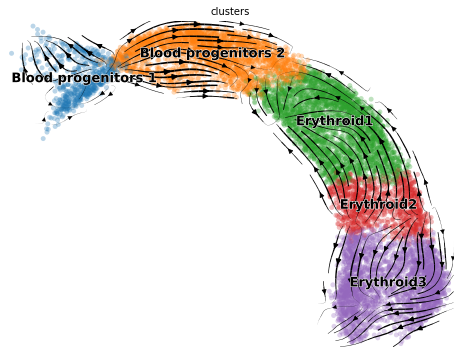

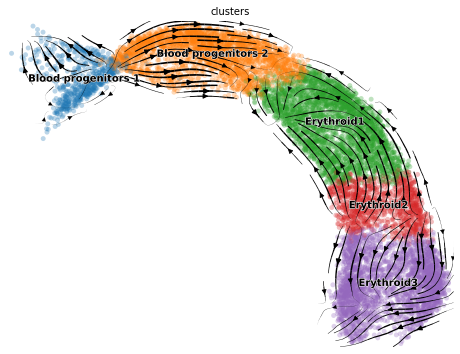

In [4]:
# Load and setup data:
adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs = 8)
scv.tl.velocity(adata, vkey='velocity', mode='dynamical')
scv.pp.neighbors(adata)
scv.tl.velocity_graph(adata, vkey='velocity')
scv.tl.velocity_embedding(adata, vkey='velocity')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_scvelo.svg')
# Calculate performance metrics:
adata.layers['velocity'][pd.isna(adata.layers['velocity'])] = 0
file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
ground_truth = pickle.load(file)
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
if exists(save_dir + dataset + '_CBDC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean'],
             index = [method])
cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
            for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
tab.loc[method,:] = cb_score + [np.mean(cb_score)]
tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
if exists(save_dir + dataset + '_ICC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_ICC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(np.unique(np.concatenate(ground_truth))) + ['Mean'],
             index = [method])
icc_score = [np.mean(metrics['In-cluster Coherence'][x]) for x in np.unique(np.concatenate(ground_truth))]
tab.loc[method,:] = icc_score + [np.mean(icc_score)]
tab.to_csv(save_dir + dataset + '_ICC_scores.csv')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.svg')

(array([2.120231e+06, 1.721106e+06, 1.855165e+06, 5.410330e+05,
        1.997340e+05, 7.533400e+04, 1.381900e+04, 6.373000e+03,
        3.591000e+03, 4.040000e+02]),
 array([ 0.        ,  5.38972079, 10.77944159, 16.16916238, 21.55888318,
        26.94860397, 32.33832477, 37.72804556, 43.11776635, 48.50748715,
        53.89720794]),
 <BarContainer object of 10 artists>)

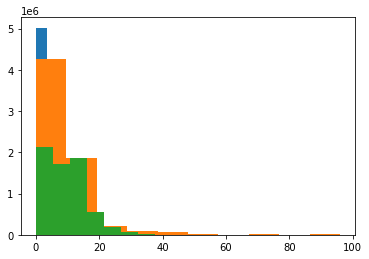

In [18]:
plt.hist(adata.layers['fit_tau'].flatten())
plt.hist(adata.layers['fit_tau_'].flatten())
plt.hist(adata.layers['fit_t'].flatten())

In [59]:
adata.layers['fit_tau']

array([[        nan,         nan,         nan, ...,         nan,
         3.26257765,         nan],
       [        nan,         nan,         nan, ...,         nan,
        10.67858499,         nan],
       [        nan,         nan,         nan, ...,         nan,
         5.28956149,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
         2.52496391,         nan],
       [        nan,         nan,         nan, ...,         nan,
         0.58398695,         nan],
       [        nan,         nan,         nan, ...,         nan,
         0.90690554,         nan]])

In [58]:
adata.layers['fit_tau_']

array([[           nan,            nan,            nan, ...,
                   nan, 3.95189394e+00,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 5.93551653e-06,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 2.01266193e+00,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan, 5.11461043e+00,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 1.27632982e+01,            nan],
       [           nan,            nan,            nan, ...,
                   nan, 1.03429986e+01,            nan]])

In [68]:
np.nanmax(adata.layers['fit_t'], axis = 1)

array([65.68054399, 70.59601203, 70.31381262, ..., 63.94686179,
       68.34261846, 59.58663512])

In [124]:
boolean = np.nanmax(adata.layers['fit_tau'], axis = 0) < np.nanmax(adata.layers['fit_tau_'], axis=0)

In [132]:
np.sum(boolean)/np.sum(~pd.isna(np.sum(adata.layers['fit_tau'], axis = 0)))

0.960960960960961

In [115]:
adata.layers['fit_tau_'][~pd.isna(adata.layers['fit_tau_'])]

array([ 2.86060294,  5.02607091,  4.44416706, ..., 10.02832724,
       10.71008431, 10.34299862])

In [142]:
adata.layers['fit_t'] - np.expand_dims(adata.var['fit_t_'], axis = 0)

array([[        nan,         nan,         nan, ...,         nan,
        -0.79022494,         nan],
       [        nan,         nan,         nan, ...,         nan,
        -0.33201843,         nan],
       [        nan,         nan,         nan, ...,         nan,
        -3.1873196 ,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
        -5.09117179,         nan],
       [        nan,         nan,         nan, ...,         nan,
         0.89091801,         nan],
       [        nan,         nan,         nan, ...,         nan,
        -1.46587827,         nan]])

In [144]:
np.nansum(adata.layers['fit_t'])

60624338.48622434

In [146]:
np.nansum(adata.layers['fit_tau'])

14784349.090793328

In [147]:
np.nansum(adata.layers['fit_tau_'])

55636122.70706905

In [150]:
np.nansum(adata.layers['fit_tau_'] - np.expand_dims(adata.var['fit_t_'], axis = 0))

1793176.5839365243

In [152]:
adata.write_h5ad('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/' + 'MouseErythroid' + '_anndata_scvelo.h5ad')